### 【データセットの用意】

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train_raw = X_train[:, np.newaxis, :, :]
y_train_raw = y_train

print(X_train_raw.shape)

(60000, 1, 28, 28)


###【以前のNNのコードの読み込み】

In [2]:
class FC:    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    def forward(self,Z):
        self.Z = Z  #Zはbackward側でも使用するのでself変数とする。
        self.A = self.Z @ self.W + self.B        
        return self.A
        
    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = (self.Z.T) @ dA 
        self.dZ = dA @ (self.W.T)
        #print(self.dW.shape) #(6760, 10) → shapeは正しそう。sample数が出てくるのはおかしい。
        #print(self.dZ.shape) #(3, 6760)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW
        return layer

class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)
    
#活性化関数（ReLU)
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, A):
        A[A<=0] = 0
        self.Z = A
        return self.Z
    
    def backward(self, dZ):
        temp = self.Z
        temp[temp>0] = 1
        return dZ * temp

#ソフトマックス関数
class Softmax():
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A)
        ex = np.exp(A)
        return ex / (np.sum(ex, axis=1)).reshape(-1,1)

    def backward(self, Z, Y):
        return 1 / len(Y) * (Z - Y)

In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題１〜問題７】

In [4]:
#ゼロつくのコードを使用している。
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

epoch: 0000.0, loss: 2.97e+00, loss_val: 2.98e+00
epoch: 0.0833, loss: 4.27e-01, loss_val: 4.13e-01
epoch: 00.167, loss: 2.91e-01, loss_val: 2.82e-01
epoch: 000.25, loss: 2.38e-01, loss_val: 2.31e-01
epoch: 00.333, loss: 2.18e-01, loss_val: 2.16e-01
epoch: 00.417, loss: 1.86e-01, loss_val: 1.88e-01
epoch: 0000.5, loss: 1.93e-01, loss_val: 1.99e-01
epoch: 00.583, loss: 1.64e-01, loss_val: 1.71e-01
epoch: 00.667, loss: 1.45e-01, loss_val: 1.53e-01
epoch: 000.75, loss: 1.47e-01, loss_val: 1.54e-01


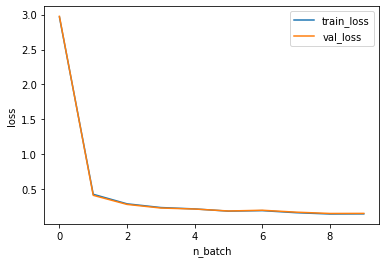

accuracy: 0.957


In [5]:
class Conv2d():  
    def __init__(self):
        self.verbose = 1
        self.lr = 0.01  #学習率
        self.sigma = 0.1 #重みの初期値のハイパーパラメータ
        self.epoch = 1
        self.batch_size = 5
        
        self.loss_e = np.array([])  #訓練データのlossを保存する。
        self.loss_v = np.array([])  #検証データのlossを保存する。

    def fit(self, X_train, y_train, X_val, y_val): 

        #w初期値の設定、更新式の設定
        Conv_Initializer = ConvSimpleInitializer(self.sigma)
        Conv_optimizer = SGD(self.lr) 
        FC_Initializer = SimpleInitializer(self.sigma)
        FC_optimizer = SGD(self.lr) 
        
        #レイヤーの設計
        self.Conv1 = Conv(X_train,  Conv_Initializer, Conv_optimizer)
        #self.Pool1 = MaxPool2D()
        self.flatten1 = flatten_2d()
        self.activation1 = ReLU()
        FC2_n_nodes1 = 6760
        FC2_n_nodes2 = 200
        self.FC2 = FC(FC2_n_nodes1, FC2_n_nodes2, FC_Initializer, FC_optimizer)
        self.activation2 = ReLU()
        FC3_n_nodes1 = 200
        FC3_n_nodes2 = 10
        self.FC3 = FC(FC3_n_nodes1, FC3_n_nodes2, FC_Initializer, FC_optimizer)
        self.activation3 = Softmax()

        #パラメータ更新
        count = 0
        for epo in range(self.epoch):
            
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                #フォワード処理
                Z2 = self._forward_prop(mini_X_train)
                
                #y_trainを　one-hot表現に変換する。
                Y = one_hot_encoding(mini_y_train)
        
                #バックワード処理
                dX = self._backward_prop(Z2, Y)
                
                #損失関数の計算
                if count % 1000 == 0:
                    self._calc_loss(X_train, y_train, X_val, y_val)
                    print(f'epoch: {self.batch_size*count/60000:06.3}, loss: {self.loss_e[-1]:.2e}, loss_val: {self.loss_v[-1]:.2e}')


                #計算サンプル数の調整
                count += 1
                #if count == 1:
                #   break
        
        #学習による損失関数の減少をプロット
        if self.verbose:
            x_idx = range(len(self.loss_e))
            plt.plot(x_idx, self.loss_e, label='train_loss')
            plt.plot(x_idx, self.loss_v, label='val_loss')
            plt.xlabel('n_batch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
        
    def _forward_prop(self, X):
        a1 = self.Conv1.forward(X)
        #p1 = self.Pool1.forward(a1)
        #f1 = self.flatten1.forward(p1)
        f1 = self.flatten1.forward(a1)
        Z1 = self.activation1.forward(f1) 
        a2 = self.FC2.forward(Z1) 
        Z2 = self.activation2.forward(a2) 
        a3 = self.FC3.forward(Z2) 
        Z3 = self.activation3.forward(a3) 
        
        return Z3
    
    def _backward_prop(self, Z3, Y):
        da3 = self.activation3.backward(Z3, Y) 
        dZ3 = self.FC3.backward(da3)
        da2 = self.activation2.backward(dZ3) 
        dZ2 = self.FC2.backward(da2)
        df1 = self.activation1.backward(dZ2)
        da1 = self.flatten1.backward(df1)   
        #dp1 = self.Pool1.backward(da1)
        #dX = self.Conv1.backward(dp1)
        dX = self.Conv1.backward(da1)
    
        return dX

    #クロスエントロピー誤差の計算
    def _cross_entropy_error(self, Y, Z):
        L = -1 / len(Y) * np.sum(Y *np.log(Z))        
        return L
    
    #訓練データ、検証データのlossを計算して保存する。
    def _calc_loss(self, X_train, y_train, X_val, y_val):
        
        #訓練データ
        Z_train = self._forward_prop(X_train)
        Y_train = one_hot_encoding(y_train)
        self.loss_e = np.append(self.loss_e, self._cross_entropy_error(Y_train, Z_train))

        #検証データ
        Z_val= self._forward_prop(X_val)
        Y_val = one_hot_encoding(y_val)
        self.loss_v = np.append(self.loss_v, self._cross_entropy_error(Y_val, Z_val))
            
        return
        
    #推定
    def predict(self, X_test):
        Z = self._forward_prop(X_test)
        y_pred = np.argmax(Z, axis=1)
        return y_pred


class Conv():    
    def __init__(self, X , Initializer, optimizer):
        self.optimizer = optimizer
        
        #入力チャンネル数 K (kは入力チャンネルのインデックス)
        self.n_in_ch = 1 
        
        #出力チャンネル数(フィルタ数) M (mは出力チャンネルのインデックス)
        self.n_out_ch = 10
        
        #フィルタサイズ（Fh, Fw)
        self.size_F = np.array([3,3])
        
        #本課題では、パディング数は０とする。
        self.pad = 0
        
        #本課題では、ストライドのサイズは１とする。
        self.stride = 1 

        #フィルタの重みを初期化する。
        self.W = Initializer.W(self.n_out_ch, self.n_in_ch, self.size_F[0], self.size_F[1])
        self.B = Initializer.B(self.n_out_ch)
                
    #フォワード処理（ゼロつくより）
    def forward(self, X):
        
        FN, C, FH, FW = self.W.shape
        N, C, H, W = X.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        col = im2col(X, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.B
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.X = X
        self.col = col
        self.col_W = col_W

        return out

    #バックワード処理（ゼロつくより）

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.dB = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.X.shape, FH, FW, self.stride, self.pad)

        self = self.optimizer.update(self)

        return dx

    
#ラベルデータをone-hot形式に変換
def one_hot_encoding(y):
    Y = np.zeros((len(y), 10))
    for i, label in enumerate(y):
        Y[i, label] = 1
    return Y
    
#クロスエントロピー誤差の計算
def _cross_entropy_error(Y, Z):
    L = -1 / len(Y) * np.sum(Y *np.log(Z))        
    return L


#Conv用のSimpleInitializer
class ConvSimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_out_ch, n_in_ch, size_Fh, size_Fw):
        return self.sigma * np.random.randn(n_out_ch, n_in_ch, size_Fh, size_Fw)

    def B(self, n_out_ch):
        return self.sigma * np.random.randn(n_out_ch,)
    
#最大プーリング
class MaxPool2D():
    def __init__(self):
        pass
    
    def forward(self, a):
        pooling_size = 2
        #print(a.shape)

        #いろいろ改訂必要
        self.ar = np.zeros((a.shape[0], int(a.shape[1]/pooling_size), int(a.shape[2]/pooling_size), a.shape[3]))
        self.back_a = np.zeros((a.shape))

        for k in range(a.shape[3]):
            for j in range(int(a.shape[2]/pooling_size)):
                for i in range(int(a.shape[1]/pooling_size)):
                    tmp = a[0, i*pooling_size : (i+1)*pooling_size, j*pooling_size : (j+1)*pooling_size, k]
                    true_posi = np.unravel_index(np.argmax(tmp), tmp.shape)
                    self.ar[0, i, j, k] += tmp[true_posi[0], true_posi[1]]
                    self.back_a[0, i*pooling_size+true_posi[0], j*pooling_size+true_posi[1], k] = 1
        
        return self.ar
    
    def backward(self, da):
        #print(da.shape)
        pooling_size = 2

        for k in range(self.back_a.shape[3]):
            for j in range(int(self.back_a.shape[2]/pooling_size)):
                for i in range(int(self.back_a.shape[1]/pooling_size)):
                    tmp = self.back_a[0, i*pooling_size : (i+1)*pooling_size, j*pooling_size : (j+1)*pooling_size, k]
                    true_posi = np.unravel_index(np.argmax(tmp), tmp.shape)
                    self.back_a[0, i*pooling_size+true_posi[0], j*pooling_size+true_posi[1], k]  = da[0, i, j, k]

        return self.back_a
    
#平滑化するクラス
class flatten_2d():
    def __init__(self):
        pass
    
    #平滑化後のサイズを(n_samples, フィルタの出力サイズ縦×横×フィルタ出力数）とする。
    def forward(self, a):
        self.input_shape = a.shape
        n_samples = a.shape[0]
        size_Nh = a.shape[1]
        size_Nw = a.shape[2]
        n_in_ch = a.shape[3]
        
        a_flatten = a.reshape(n_samples, size_Nh*size_Nw*n_in_ch)
      
        return a_flatten
    
    def backward(self, df):
        return df.reshape(self.input_shape)

#訓練データ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=0)
    
#機械学習インスタンスの作成
cnn2d = Conv2d()

#機械学習
cnn2d.fit(X_train, y_train, X_test, y_test)

#機械学習による推定
y_pred = cnn2d.predict(X_test)

#print("y_pred", y_pred)
#print("y_test", y_test)

#精度の確認
acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)